In [4]:
import tskit
import msprime
import numpy as np

In [5]:
def print_windows(left, right):
    print('left: ', [(left[i], left[i + 1]) for i in range(len(left) - 1)])
    print('right: ', [(right[i], right[i + 1]) for i in range(len(right) - 1)])

def check_windows(windows, num_windows, ts_length, print_=True):
    left_len, right_len = num_windows
    left_windows = windows[:left_len]
    right_windows = windows[left_len:]

    if print_:
        print_windows(left_windows, right_windows)

    for i in range(left_len - 1):
        if (left_windows[i] >= left_windows[i + 1]):
            raise ValueError(f'Bad window (left) [{left_windows[i]}, {left_windows[i + 1]})')

    for i in range(right_len - 1):
        if (right_windows[i] >= right_windows[i + 1]):
            raise ValueError(f'Bad window (right) {right_windows[i]}, {right_windows[i + 1]}')

    if left_windows[left_len - 1] > ts_length:
        raise ValueError('Left windows out of bounds')

    if right_windows[right_len - 1] > ts_length:
        raise ValueError('Right windows out of bounds')

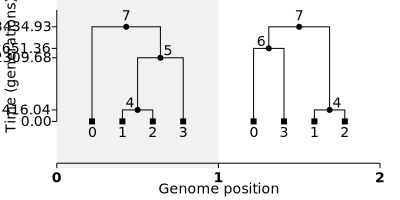

In [6]:
ts = msprime.sim_ancestry(
    samples=2,
    population_size=1000,
    recombination_rate=5e-4,
    sequence_length=2,
    random_seed=123
)
ts.draw_svg(y_axis=True)

In [7]:
def get_tree_ranges(windows, num_windows, ts):
    ranges = np.zeros(num_windows, np.uint64)
    scales = np.zeros(num_windows, np.float64)
    win = 0
    t = 0
    tree = ts.at_index(t)
    while True:
        start = windows[win]
        stop = windows[win + 1]
        # seek to start
        while tree.interval.left < start:
            t += 1
            tree = ts.at_index(t)
        ranges[win] = t
        scales[win] = min(tree.interval.right, stop) - max(tree.interval.left, start)
        # seek within range
        while stop < tree.interval.right:
            win += 1
            ranges[win] = t
            scales[win] = min(tree.interval.right, stop) - max(tree.interval.left, start)
            if win == num_windows - 1:
                return ranges, scales
            start = windows[win]
            stop = windows[win + 1]
        win += 1
        ranges[win] = t
        scales[win] = min(tree.interval.right, stop) - max(tree.interval.left, start)
        if win == num_windows - 1:
            return ranges, scales
    return ranges, scales

In [8]:
# # TODO: fix this case
# windows = [0, 1.3, 1.5, 1.8, 2]
# check_windows(windows + windows, (len(windows), len(windows)), ts.sequence_length)
# get_tree_ranges(windows, len(windows), ts)

In [9]:
windows = [0, .1, .2, .3, 1, 1.2, 1.5, 1.8, 2]
check_windows(windows + windows, (len(windows), len(windows)), ts.sequence_length)
get_tree_ranges(windows, len(windows), ts)

left:  [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 1), (1, 1.2), (1.2, 1.5), (1.5, 1.8), (1.8, 2)]
right:  [(0, 0.1), (0.1, 0.2), (0.2, 0.3), (0.3, 1), (1, 1.2), (1.2, 1.5), (1.5, 1.8), (1.8, 2)]


(array([0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=uint64),
 array([0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.3, 0.3, 0.2]))

In [13]:
def two_branch_stat(ts, left_windows, left_span, right_windows, right_span):
    e_ijij = 0
    e_ijik = 0
    e_ijkl = 0
    

In [16]:
from itertools import combinations

In [18]:
a == b

True

In [19]:
# ts = msprime.sim_ancestry(
#     samples=3,
#     population_size=100,
#     recombination_rate=2e-8,
#     sequence_length=1e5,
#     random_seed=122
# )

# ts.draw_svg(y_axis=True)

In [20]:
def pairwise_windows(ts, d):
    # S, T are the left and right trees
    S = ts.first()
    T = ts.at(d) 
    l = 0
    r = d
    L = []  # an empty list

    # while the right end of the last window doesn't reach the end point of the entire sequence
    while r < ts.sequence_length: 
        # non-overlapping length candidates 
        # ld is the non-overlapping length from the left tree and rd is from the right tree
        ld = S.interval.right - l  
        rd = T.interval.right - r  
        L.append([S.index, T.index, min(ld, rd)])

        
        # slide the interval to the right side
        if ld > rd:
            l += rd

            # end condition of the entire process
            if ts.sequence_length == (r + rd):
                break
            T.next()
            r = T.interval.left  # interval left bound of T
        # slide the interval to the left side
        else: 
            r += ld
            S.next()
            l = S.interval.left # interval left bound of S
    return L

In [21]:
pairwise_windows(ts, .001)

[[0, 0, 0.999], [0, 1, 0.0010000000000000009], [1, 1, 0.9990000000000001]]

In [28]:
from itertools import combinations

In [29]:
list(combinations(ts.samples(), 2))

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [63]:
def get_tmrca_for_all_samples_all_trees(ts):
    return [
        {(a, b): tree.tmrca(a, b) for a, b in combinations(ts.samples(), 2)}
        for tree in ts.trees()
    ]

In [66]:
get_tmrca_for_all_samples_all_trees(ts)

[{(0, 1): 3434.9319915864203,
  (0, 2): 3434.9319915864203,
  (0, 3): 3434.9319915864203,
  (1, 2): 416.03913361240484,
  (1, 3): 2309.6791068836915,
  (2, 3): 2309.6791068836915},
 {(0, 1): 3434.9319915864203,
  (0, 2): 3434.9319915864203,
  (0, 3): 2651.3610982033315,
  (1, 2): 416.03913361240484,
  (1, 3): 3434.9319915864203,
  (2, 3): 3434.9319915864203}]

In [17]:
b = []
n = 5
for i, j in combinations(range(n), 2):
    b.append((i, j))
    for k in range(n):
        if k == i or k == j:
            continue
        else:
            b.append((i, j, k))
            for l in range(k + 1, n):
                if (l == i or l == j):
                    continue
                else:
                    b.append((i, j, k,l))

In [144]:
pairwise_windows(ts, .5)

[[0, 0, 0.5], [0, 1, 0.5], [1, 1, 0.5]]

In [146]:
np.arange(.5, 2, .5)

array([0.5, 1. , 1.5])

In [151]:
windows = list(np.arange(0, 2, .5))
check_windows(windows + windows, (len(windows), len(windows)), ts.sequence_length)
get_tree_ranges(windows, len(windows), ts)

left:  [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5)]
right:  [(0.0, 0.5), (0.5, 1.0), (1.0, 1.5)]


(array([0, 0, 1, 1], dtype=uint64), array([0.5, 0.5, 0.5, 0.5]))

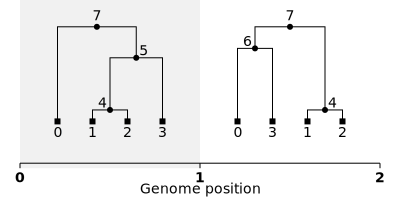

In [149]:
ts.draw_svg()

In [25]:
tree = ts.at(0)

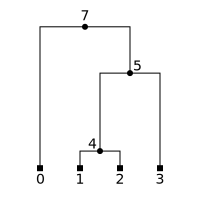

In [26]:
tree.draw_svg()

In [43]:
for c in combine(ts.samples()):
    if len(c) == 2:
        i, j = c
        print('(', i, ',' , j, ')', tree.mrca(i, j))
    elif len(c) == 3:
        i, j, k = c
        print('(', i, ',' , j, ',' , k, ')', tree.mrca(i, j), tree.mrca(i, k))
    elif len(c) == 4:
        i, j, k, l = c
        print('(', i, ',' , j, ',' , k, ',' , l, ')', tree.mrca(i, j), tree.mrca(k, l))
    else:
        raise ValueError

( 0 , 1 ) 7
( 0 , 1 , 2 ) 7 7
( 0 , 1 , 2 , 3 ) 7 5
( 0 , 1 , 3 ) 7 7
( 0 , 2 ) 7
( 0 , 2 , 1 ) 7 7
( 0 , 2 , 1 , 3 ) 7 5
( 0 , 2 , 3 ) 7 7
( 0 , 3 ) 7
( 0 , 3 , 1 ) 7 7
( 0 , 3 , 1 , 2 ) 7 4
( 0 , 3 , 2 ) 7 7
( 1 , 2 ) 4
( 1 , 2 , 0 ) 4 7
( 1 , 2 , 0 , 3 ) 4 7
( 1 , 2 , 3 ) 4 5
( 1 , 3 ) 5
( 1 , 3 , 0 ) 5 7
( 1 , 3 , 0 , 2 ) 5 7
( 1 , 3 , 2 ) 5 4
( 2 , 3 ) 5
( 2 , 3 , 0 ) 5 7
( 2 , 3 , 0 , 1 ) 5 7
( 2 , 3 , 1 ) 5 4


In [35]:
def combine(samples):
    n = len(samples)
    for i, j in combinations(range(n), 2):
        yield i, j
        for k in range(n):
            if k == i or k == j:
                continue
            else:
                yield i, j, k
                for l in range(k + 1, n):
                    if (l == i or l == j):
                        continue
                    else:
                        yield i, j, k, l

In [36]:
list(combine(ts.samples()))

[(0, 1),
 (0, 1, 2),
 (0, 1, 2, 3),
 (0, 1, 3),
 (0, 2),
 (0, 2, 1),
 (0, 2, 1, 3),
 (0, 2, 3),
 (0, 3),
 (0, 3, 1),
 (0, 3, 1, 2),
 (0, 3, 2),
 (1, 2),
 (1, 2, 0),
 (1, 2, 0, 3),
 (1, 2, 3),
 (1, 3),
 (1, 3, 0),
 (1, 3, 0, 2),
 (1, 3, 2),
 (2, 3),
 (2, 3, 0),
 (2, 3, 0, 1),
 (2, 3, 1)]